In [1]:
import pandas as pd
import numpy as np

* Load in the data from a csv file

In [2]:
colNames = ['sbjId','faceId','nameId','conflict','zRT','RT']
df_group = pd.read_csv('ISPC_behavior.csv', header=0, names=colNames)
print(df_group.shape)
np.unique(df_group.sbjId)

(19488, 6)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

* The following analysis will loop through each subject to obtain the best fitting learning rates

In [3]:
#for S in np.unique(df_group.sbjId):
S = 1
df = df_group.loc[df_group.sbjId==S,:]
df.head()

,sbjId,faceId,nameId,conflict,zRT,RT
0,1,8,8,0,-0.240255,577.219800
1,1,5,5,0,0.820208,665.302282
2,1,7,6,1,2.027002,765.539121
3,1,5,6,1,2.946576,841.919275
4,1,8,7,1,-0.230702,578.013324


* The idea is to use subjects' behavior (response time, df.RT) and the given conflict-level trial sequence (df.conflict) to infer their learning rates
* To do so, we'll apply a simple temporal difference learning [or reinforcement learning] algorithm (Sutton & Barto, 1998) because we assume that's how subjects learn to predict each trial's conflict-level 
* We will exhaustively search for the learning rates that best described subjects' behavior (RT)

# 1. Let's write a function that will return trial-by-trial conflict prediction based on a given conflict sequence and learning rate(alpha) 

In [4]:
def conflictPred(c,alpha):
    c=np.array(c)
    p = np.zeros(len(c))+0.5
    for i in range(len(c)-1):
        p[i+1] = p[i]+ alpha*(c[i]-p[i])
    return p

* There are two potential sources of conflict prediction: from face stimuli and from name stimuli
* In the Stroop task - subjects see a face with overlapping name (this name could be that face's name [conflict level=0] or someone else's name [conflict level =1])
* Subjects only need to pay attention to the face to do the task, but the name could be helpful (e.g., if it is that face's name)
* We design the task such that in one condition, face information is predictive of the conflict level and in another conditoin, name information is predictive of the conflict level
* We want to know- whether subjects use face/name information respectively to predict conflict level and facilitate their task performance

In [5]:
alpha_face = 0.01
alpha_name = 0.01
for i in range(0,8,1):  # 0-7 (8 unique ids)
    df.loc[df.faceId==i+1,'CP_face'] = conflictPred(df.loc[df.faceId==i+1, 'conflict'], alpha_face)
    df.loc[df.nameId==i+1,'CP_name'] = conflictPred(df.loc[df.nameId==i+1, 'conflict'], alpha_name)
df.head()            

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name
0,1,8,8,0,-0.240255,577.219800,0.500,0.500
1,1,5,5,0,0.820208,665.302282,0.500,0.500
2,1,7,6,1,2.027002,765.539121,0.500,0.500
3,1,5,6,1,2.946576,841.919275,0.495,0.505
4,1,8,7,1,-0.230702,578.013324,0.495,0.500


# 2. Let's see which combination of learning rates (a learning model) describes the subject's behavior
- use RT to evaluate this model
- calculate the sume of squared errors (SSEs) for each combination of alpha_face and alpha_name
- find the smallest SSEs

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

* Construct design matrix, fit the data, and calculate the Sum of squared errors (SSEs)

4264115.94272


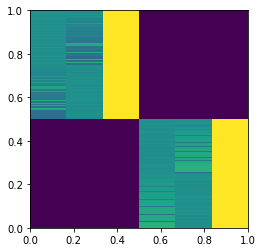

In [7]:
idxC = df[(df.conflict==0) & (df.zRT.notnull())].index
idxI = df[(df.conflict==1) & (df.zRT.notnull())].index
RT = np.concatenate((np.array(df.loc[idxC,'RT']), np.array(df.loc[idxI,'RT'])), axis=0)
constC = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxC),dtype=int))
constI = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxI),dtype=int))
#
dmC = df.loc[idxC,['CP_face','CP_name']]
dmC = np.concatenate((dmC, constC), axis=1)
dmI = df.loc[idxI,['CP_face','CP_name']]        
dmI = np.concatenate((dmI, constI), axis=1)
dmI = dmI[:,[3,4,5,0,1,2]]
DM = np.concatenate((dmC, dmI),axis=0)
plt.imshow(DM,extent=[0,1,0,1])
diff =  RT - np.dot(np.dot(DM, np.linalg.pinv(DM)),RT)
SSE = np.square(diff).sum()
print(SSE)

* compare SSE across all pairs of alpha_face and alpha_name
* Preserve the model with the smallest (best fitting) SSEs

In [ ]:
bestSSE = -1
if (bestSSE <0)|(SSE < bestSSE):
    bestAlpha = [alpha_face, alpha_name]
    bestSSE = SSE
    df_wCP  = df

# 3. Putting it all together: 

In [ ]:
for S in np.unique(df_group.sbjId):    
    df = df_group.loc[df_group.sbjId==S,:]
    
    # for later Design matrix construction
    idxC = df[(df.conflict==0) & (df.zRT.notnull())].index
    idxI = df[(df.conflict==1) & (df.zRT.notnull())].index
    RT = np.concatenate((np.array(df.loc[idxC,'RT']), np.array(df.loc[idxI,'RT'])), axis=0)
    constC = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxC),dtype=float))
    constI = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxI),dtype=float))
    
    # Run exhaustive search for the best fitting alpha_face, alpha_name using RT data     
    bestSSE = -1        
    for alpha_face in np.arange(0.01, 1, 0.01):
        for alpha_name in np.arange(0.01, 1, 0.01):            
            
            # plug in the alphas and derive CP_face and CP_name
            for i in range(0,8,1):  # 0-7 (8 unique ids)
                df.loc[df.faceId==i+1,'CP_face'] = conflictPred(df.loc[df.faceId==i+1,'conflict'], alpha_face)
                df.loc[df.nameId==i+1,'CP_name'] = conflictPred(df.loc[df.nameId==i+1,'conflict'], alpha_name)
            
            # Construct design matrix and calculate the Sum of squared errors (SSEs) 
            dmC = df.loc[idxC,['CP_face','CP_name']]
            dmC = np.concatenate((dmC, constC), axis=1)
            dmI = df.loc[idxI,['CP_face','CP_name']]        
            dmI = np.concatenate((dmI, constI), axis=1)
            dmI = dmI[:,[3,4,5,0,1,2]]
            DM = np.concatenate((dmC, dmI),axis=0)            
            diff =  RT - np.dot(np.dot(DM, np.linalg.pinv(DM)),RT)
            SSE = np.square(diff).sum()            
            
            # presever the best model
            if (bestSSE <0)|(SSE < bestSSE):
                bestAlpha = [alpha_face, alpha_name]
                bestSSE = SSE
                df_wCP  = df                
    
    # end of a subject's modeling, put best-fitting CP back to group df and save the best-fitting alphas
    df_gp_wCP = pd.concat([df_gp_wCP, df_wCP], axis=0)
    gp_alphas.loc[SCNT, 'sbjId']=S
    gp_alphas.loc[SCNT, 'alpha_face'] = bestAlpha[0]
    gp_alphas.loc[SCNT, 'alpha_name'] = bestAlpha[1]

# end of all subjects' modeling
df_gp_wCP.to_pickle('df_wCP.pkl')
gp_alphas.to_pickle('df_alphas.pkl')

C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
